In this notebook, we'll be using style transfer to create stylized versions of images based on the visual style of another image.

Below we download the image we'll be using as our style reference image.

In [1]:
!wget https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg

--2020-08-28 11:45:14--  https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 13.32.240.31, 13.32.240.65, 13.32.240.114, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|13.32.240.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478418 (467K) [image/jpeg]
Saving to: ‘starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg’

starry-night-print- 100%[===================>] 467.21K  1.31MB/s    in 0.3s    

2020-08-28 11:45:15 (1.31 MB/s) - ‘starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg’ saved [478418/478418]



Next, we download our base image to modify.

In [2]:
!wget https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/providence-skyline-nightscape-eddy-bernardo.jpg

--2020-08-28 11:45:27--  https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/providence-skyline-nightscape-eddy-bernardo.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 13.32.240.65, 13.32.240.31, 13.32.240.114, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|13.32.240.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103090 (101K) [image/jpeg]
Saving to: ‘providence-skyline-nightscape-eddy-bernardo.jpg’

providence-skyline- 100%[===================>] 100.67K   597KB/s    in 0.2s    

2020-08-28 11:45:28 (597 KB/s) - ‘providence-skyline-nightscape-eddy-bernardo.jpg’ saved [103090/103090]



In this block of code, we: 

- handle data loading and preprocessing:
  - write a `preprocess` function to process the images
  - an inverse to `preprocess`, the `deprocess` function
  - build an `input_tensor` that contains:
    - our original `base_image`
    - our `style_reference_image`
    - our `combination_image`, which has the structure of the `base_image` but uses the visual style of `style_reference_image`
  - load our model we will use for style transfer, a VGG16 `model` with pre-trained weights from ImageNet
  - define a `outputs_dict` which has the outputs of each layer
- create a set of functions and classes to handle the caluclations of the gradients with respect to the `loss`, which we will use to optimize the training of our model:
  - a `style_loss` function that we will use to ensure a replication of the style of the `style_reference_image`
    - we define function that calculates the `gram_matrix` of a set of vectors which we will use to calculate our `style_loss`
  - a `content_loss` function to ensure that the `combination_image` shares the same structural features as the `base_image
  - a `total_variation_loss` use to ensure the `combination_image` is locally coherent
  - define an `Evaulator` object to handle calculation of the loss and gradients:
    - we use the funciton `eval_loss_and_grads` to get these values
- finally we optimize the `combination_image` using the optimization algorithm L-BFGS, training it 20 `iterations, displaying the image and printing the `loss` each time

In [3]:
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing import image

from keras.applications import vgg19
from keras import backend as K

base_image_path = 'providence-skyline-nightscape-eddy-bernardo.jpg'
style_reference_image_path = 'starry-night-print-by-vincent-van-gogh-vincent-van-gogh.jpg'
iterations = 20

# these are the weights of the different loss components
# total_variation_weight = args.tv_weight
total_variation_weight = 4.0
# style_weight = args.style_weight
style_weight = 10.0
# content_weight = args.content_weight
content_weight = 6.0

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# util function to open, resize and format pictures into appropriate tensors

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))

    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    print('at_iteration_%d.png' % i)
    display(image.array_to_img(img))

Output hidden; open in https://colab.research.google.com to view.

Here we show our image we learned after training our style transfer model.

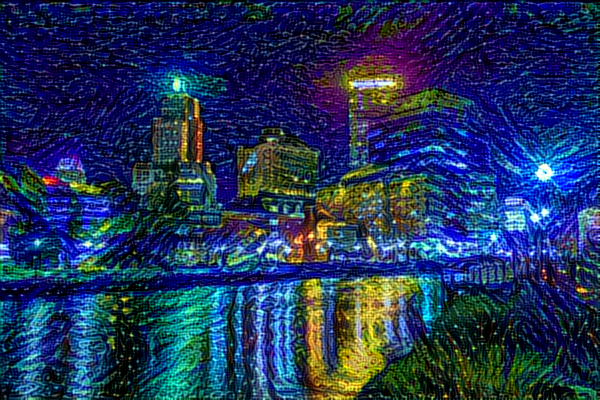

In [4]:
from keras.preprocessing import image
display(image.array_to_img(img))